# Manifold Decoding

### Libraries Import

In [143]:
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.ndimage import gaussian_filter1d
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

### Loading the Features Data

In [144]:
load_dir = '../data/02_features'
X_features = np.load(f'{load_dir}/features.npy')
y_labels = np.load(f'{load_dir}/labels.npy')

print(f"Loaded the Features Data: {X_features.shape}")

Loaded the Features Data: (100, 61, 10)


### Standardization

In [145]:
# Reshaping trials and time
n_trials, n_time, n_feats = X_features.shape
X_flat = X_features.reshape(n_trials * n_time, n_feats)

# Z-Scoring
mu = np.mean(X_flat, axis=0)
sigma = np.std(X_flat, axis=0)

X_stand = (X_flat - mu) / sigma

print(f"Standardized Matrix Shape: {X_stand.shape}")
print(f"Standard Deviation: {np.round(np.std(X_stand), 2)}")
print(f"Mean: {np.round(np.mean(X_stand), 2)}")

Standardized Matrix Shape: (6100, 10)
Standard Deviation: 1.0
Mean: -0.0


### Principal Component Analysis

In [146]:
# Computing the covariance matrix
N = X_stand.shape[0]
covariance_matrix = (X_stand.T @ X_stand) / (N - 1)

# Eigendecomposition
eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

# Sorting eigen values
sorted_indices = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[sorted_indices]
eigen_vecs = eigen_vecs[:, sorted_indices]

# Explained variance ratio
explained_variance = eigen_vals / np.sum(eigen_vals)

print("Explained Variance (PC1, PC2, PC3):", np.round(explained_variance[:3] * 100, 1), "%")

Explained Variance (PC1, PC2, PC3): [25.2 19.5 11.4] %


### 3D Subspace Projection

In [147]:
# Selecting first 3 principal components
W_pca = eigen_vecs[:, :3]

# Projecting the data
X_pca = X_stand @ W_pca

# Reshaping back
X_pca_3d = X_pca.reshape(n_trials, n_time, 3)

print(f"Projected Data Shape: {X_pca_3d.shape}")

Projected Data Shape: (100, 61, 3)


### Static Visualization

Plot saved to ../data/03_results


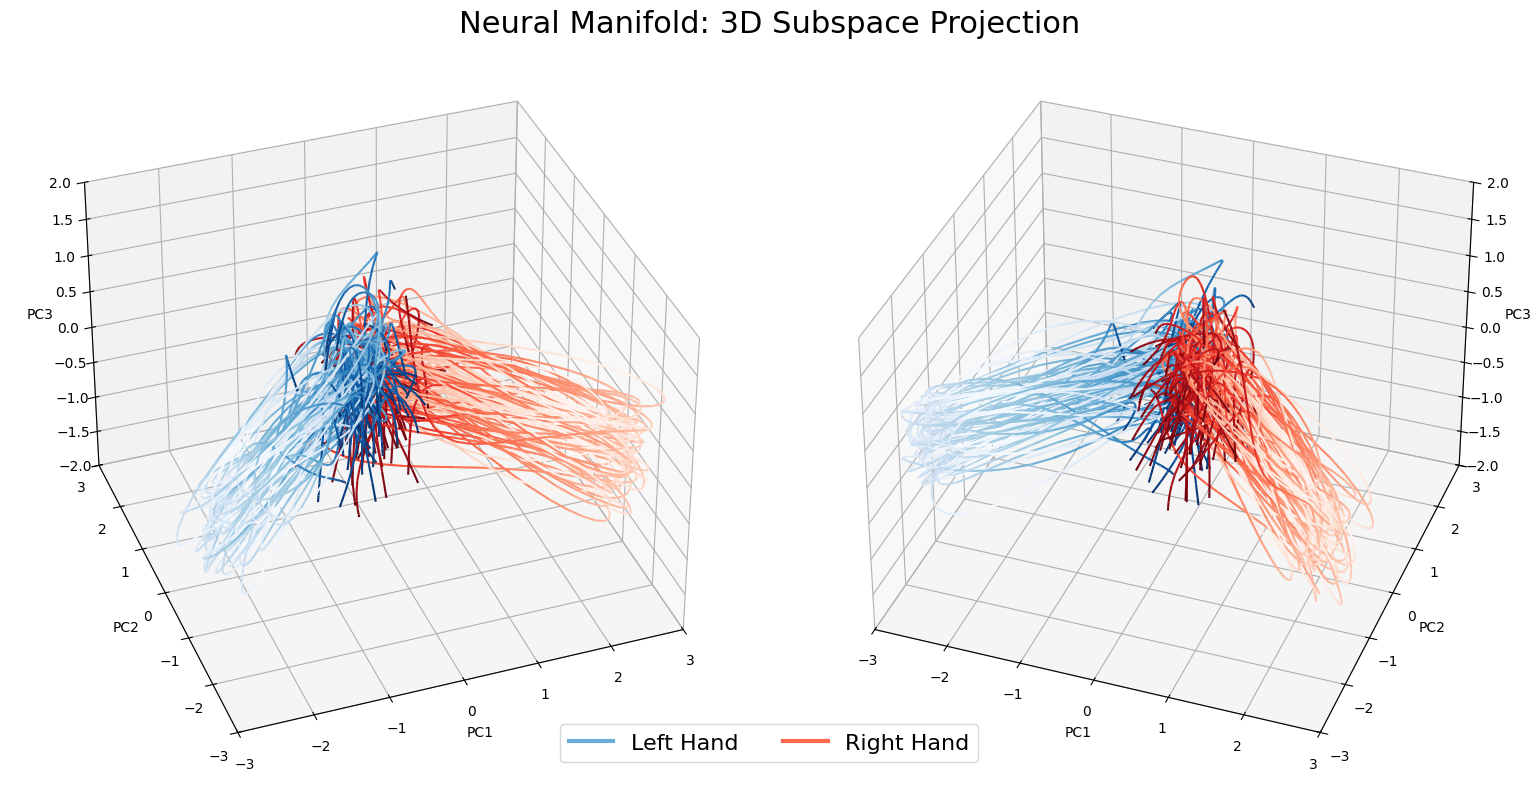

In [ ]:

# Preparing Data
left_idxs = np.where(y_labels == 'Left')[0]
right_idxs = np.where(y_labels == 'Right')[0]
sigma_smooth = 4.5

# Plotting function
def plot_symmetric_gradient(ax, x, y, z, cmap, base_alpha=0.9, lw=2):
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n_seg = len(segments)
    
    t = np.linspace(0.0, 1.0, n_seg)
    color_indices = 1.0 - 2.0 * np.abs(t - 0.5)
    
    colors = cmap(color_indices)
    colors[:, 3] = base_alpha 

    lc = Line3DCollection(segments, colors=colors, linewidths=lw)
    ax.add_collection(lc)

# figure setup
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Neural Manifold: 3D Subspace Projection", fontsize=22)

configs = [
    (35, 250),
    (35, 290)
]

all_data = X_pca_3d.reshape(-1, 3)
xlims = (-3.0, 3.0)
ylims = (-3.0, 3.0)
zlims = (-2.0, 2.0)

# Plotting loop
for i, (elev, azim) in enumerate(configs):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    
    # Left trials
    for idx in left_idxs:
        traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
        plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                                cmap=plt.cm.Blues_r, base_alpha=1.0, lw=1.5)

    # Right trials
    for idx in right_idxs:
        traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
        plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                                cmap=plt.cm.Reds_r, base_alpha=1.0, lw=1.5)


    ax.view_init(elev=elev, azim=azim)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)

# Creating legend
proxy_left = mlines.Line2D([], [], color=plt.cm.Blues_r(0.5), lw=3, label='Left Hand')
proxy_right = mlines.Line2D([], [], color=plt.cm.Reds_r(0.5), lw=3, label='Right Hand')

fig.legend(handles=[proxy_left, proxy_right], loc='upper center', 
           ncol=2, fontsize=16, frameon=True, bbox_to_anchor=(0.5, 0.1))

# Saving the figure
save_dir = '../data/03_results'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'neural_manifold_static.png')

plt.savefig(save_path, dpi=300)
print(f"Plot saved to {save_dir}")

plt.tight_layout()
plt.show()

### Animated Visualization

In [ ]:


# Preparing data
left_idxs = np.where(y_labels == 'Left')[0]
right_idxs = np.where(y_labels == 'Right')[0]
sigma_smooth = 4.5

# Plotting function
def plot_symmetric_gradient(ax, x, y, z, cmap, base_alpha=0.9, lw=2):
    """
    Plots a 3D trajectory with a 'Dark -> Bright -> Dark' color gradient.
    """
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n_seg = len(segments)
    
    t = np.linspace(0.0, 1.0, n_seg)
    color_indices = 1.0 - 2.0 * np.abs(t - 0.5)
    
    colors = cmap(color_indices)
    colors[:, 3] = base_alpha 

    lc = Line3DCollection(segments, colors=colors, linewidths=lw)
    ax.add_collection(lc)

# Figure setup
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
fig.suptitle("Neural Manifold: 3D Subspace Projection", fontsize=18)

xlims = (-3.0, 3.0)
ylims = (-3.0, 3.0)
zlims = (-2.0, 2.0)

# Plotting loop

# Left trials
for idx in left_idxs:
    traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
    plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                            cmap=plt.cm.Blues_r, base_alpha=1.0, lw=1.5)

# Right trials
for idx in right_idxs:
    traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
    plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                            cmap=plt.cm.Reds_r, base_alpha=1.0, lw=1.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_zlim(zlims)

# Legend
proxy_left = mlines.Line2D([], [], color=plt.cm.Blues_r(0.5), lw=3, label='Left Hand')
proxy_right = mlines.Line2D([], [], color=plt.cm.Reds_r(0.5), lw=3, label='Right Hand')
ax.legend(handles=[proxy_left, proxy_right], loc='upper right', fontsize=12)

# animation function
def update(frame):
    ax.view_init(elev=35, azim=frame)
    return fig,

# Creating the animation
anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50, blit=False)

# Saving the animation
save_dir = '../data/03_results'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'neural_manifold_rotating.gif')

print("Generating GIF... this may take a moment.")
anim.save(save_path, writer=PillowWriter(fps=20))
print(f"GIF saved to {save_dir}")

plt.close()

Generating GIF... this may take a moment.
GIF saved to ../data/03_results
